# Wrangle and Analyze Data

## Table of Contents
## [Task Overview:](#overview)
### [The Data](#data)
## Step 1: Gather Data
## Step 2: Assessing data
## Step 3: Cleaning Data
### Twitter Archive
### Predictions
### Extra Tweet Data
### Combine the datasets
## Step 4: Storing Data
## Step 5: Analyzing and Visualizing Data
### Insight One
### Insight Two
### Insight Three
### [Bonus Insight](#bonus)

Note: I understand how to create a TOC and I understand why it is a desirable feature to have in a long document. I also know how long it will take to complete and that it is not required by the rubric.

## Task Overview: <a id="overview"></a>

1. Gather - Gather up the various datasets

2. Assess - Assess the quality and issues with the data sets.

3. Clean - Tidy up the data sets, removing bad data, combining into a single set.

4. Store - Store the cleaned and combined dataset.

5. Analyze and Visualize - Analyze the data and support the analysis with good visualizations of the data.

Report in Two Parts:
<li>Document the data wrangling efforts
<li>Document and present the data analyses and visualizations

### The Data <a id="data"></a>
This project includes three datasets

##### Enhanced Twitter Archive
##### Additional Data via the Twitter API
##### Image Predictions File


In [1]:
#!pip install tabulate

In [2]:
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import os
import time
import datetime
import calendar
import random
import matplotlib.pyplot as plt
import seaborn as sb
import tabulate

from scipy.stats import pearsonr
%matplotlib inline
pd.set_option('display.max_colwidth', None)

## Step 1: Gather Data

### Enhanced Twitter Archive
This is the twitter archive dataset Udacity got from WeRateDogs. When Udacity received this, it contained basic tweet data for some 5000+ tweets. It is missing some fields that are in each tweet, this is provided to the student as an exercise in using an API. One field included in this archive is the text of each tweet. From this Udacity has extracted the name of the dog, and rating, in the form of a numerator and denominator and the standardized silly doggie descriptors used by WeRateDogs, referred to as "stage." These are doggo, floofer, pupper, and puppo. This modified archive is provided to the student as a 'Twitter archive "enhanced."' Tweets with out photos or ratings were removed leaving only 2356 in the archive.

In [3]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


### Image Predictions File
The second data source for the project is a file created by Udacity including additional information about the dogs in the tweets:
> Udacity ran every image in the WeRateDogs Twitter archive through a neural network that can classify breeds of dogs*. The results: a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).

Columns in that table are:

* tweet_id is the last part of the tweet URL after "status/" → https://twitter.com/dog_rates/status/889531135344209921
* p1 is the algorithm's #1 prediction for the image in the tweet
* p1_conf is how confident the algorithm is in its #1 prediction
* p1_dog is whether or not the #1 prediction is a breed of dog
* p2 is the algorithm's second most likely prediction
* p2_conf is how confident the algorithm is in its #2 prediction
* p2_dog is whether or not the #2 prediction is a breed of dog
* etc.

In [4]:
ip_URL = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
image_predictions = requests.get(ip_URL)
image_predictions.headers
with open(ip_URL.split('/')[-1], mode='wb') as file:
    try:
        file.write(image_predictions.content)
    finally:
        file.close()

In [5]:
image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Additional Data via the Twitter API

>Gather each tweet's **retweet count** and **favorite ("like") count** at the minimum and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file.

Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) **tweet ID, retweet count, and favorite count.**

**Note: do not include your Twitter API keys, secrets, and tokens in your project submission.**

In [6]:
# import tweepy

# build the Twitter accss object
# api_key = "REDACTED"
# api_key_secret = "REDACTED"

# bearer_token = "REDACTED"

# access_token = "REDACTED"
# access_token_secret = "REDACTED"

# authenticator = tweepy.OAuthHandler(api_key, api_key_secret)
# authenticator.set_access_token(access_token, access_token_secret)

#tweet_ids = [892420643555336193, 892177421306343426]

# authenticator = tweepy.OAuthHandler(api_key, api_key_secret)
# authenticator.set_access_token(access_token, access_token_secret)
# api = tweepy.API(authenticator, wait_on_rate_limit=True)

In [7]:
# import tweepy
# from tweepy import OAuthHandler
# import json
# from timeit import default_timer as timer

# api = tweepy.API(authenticator, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
# tweet_ids = twitter_archive.tweet_id.values
# len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
# count = 0
# fails_dict = {}
# start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
# with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
#     for tweet_id in tweet_ids:
#         count += 1
#         print(str(count) + ": " + str(tweet_id))
#         try:
#             tweet = api.get_status(tweet_id, tweet_mode='extended')
#            tweet = api.get_status(tweet_id, tweet_mode='compat')
#             print("Success")
#             json.dump(tweet._json, outfile)
#             outfile.write('\n')
#         except tweepy.TweepError as e:
#             print("Fail")
#             fails_dict[tweet_id] = e
#             pass
# end = timer()
# print(end - start)
# print(fails_dict)

It seems that the twitter api is no longer available for this use without charge. Even the sample code returns the error:

<code><font color=990000><b>Forbidden</b></font>: 403 Forbidden
453 - You currently have access to a subset of Twitter API v2 endpoints and limited v1.1 endpoints (e.g. media post, oauth) only. If you need access to this endpoint, you may need a different access level. You can learn more here: https://developer.twitter.com/en/portal/product</code>

In [8]:
# read in the JSON data from the text file, and save to a DataFrame
tweet_json_file = 'tweet-json.txt'
tweet_json_data = []

with open(tweet_json_file, 'r') as json_file:
    # read the first line to start the loop
    line = json_file.readline()
    while line:
        data = json.loads(line)

        # extract variables from the JSON data
        data_id = data['id']
        data_retweet_count = data['retweet_count']
        data_favorite_count = data['favorite_count']
        
        # create a dictionary with the JSON data, then add to a list
        json_data = {'tweet_id': data_id, 
                     'retweet_count': data_retweet_count, 
                     'favorite_count': data_favorite_count
                    }
        tweet_json_data.append(json_data)

        # read the next line of JSON data
        line = json_file.readline()
        # ----- while -----

# convert the tweet JSON data dictionary list to a DataFrame
tweet_extra = pd.DataFrame(tweet_json_data, 
                                   columns = ['tweet_id',
                                              'retweet_count',
                                              'favorite_count'])

tweet_extra.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


## Step 2: Assessing data

### Twitter Archive

In [9]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

#### First Observations:
There are 17 fields to consider.

`tweet_id`
: The Dtype seems appropriate. All rows have data. I should check minimum and maximum IDs as well as a few from throughout the range of values.

`in_reply_to_status_id` and `in_reply_to_user_id`
: The Dtype should probably be int64. Both of these fields are empty for most records. I would expect two or three times as many rows to have values, or for none of them to have values. This data will need to be examined.

`timestamp`
: This should be of Dtype `datetime` not `object`. All rows have data, I will need to check to see if they are within the expected date range. (Tidiness Count: 1)

`source`
: The Dtype seems appropriate. All rows have data.

`text`
: The Dtype seems appropriate. All rows have data.

`retweeted_status_id`, `retweeted_status_user_i`
: The Dtype are numeric, but they are float not int, this could be an issue. Most rows do not contain any data, this may indicate that they are WeRateDogs retweeting someone else, this should be checked, if they are, the records should be removed, as the instructions state, "You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets."

`retweeted_status_timestamp`
: This should be of Dtype `datetime` not `object`. As with the other two `retweet` columns, most records are NaN for this column.

`expanded_urls`
: The Dtype seems appropriate. Not all rows have data, this may indicate a data quality problem, or just a tidiness issue.

`rating_numerator` and `rating_denominator`
: The Dtype seems appropriate. All rows have data.

`name`
: The Dtype seems appropriate. All rows have data.

`doggo`, `floofer`, `pupper`, and `puppo`
: The Dtype could be appropriate. I would expect either int or bool values, this may be a tidiness issue. All rows have data.

#### `tweet_id`

In [10]:
twitter_archive.tweet_id.min(), twitter_archive.tweet_id.max()

(666020888022790149, 892420643555336193)

In [11]:
# pull five random tweet_ids from the data frame
twitter_archive.tweet_id.sample(n=5)

1613    685315239903100929
414     822859134160621569
390     826240494070030336
60      880465832366813184
1057    742150209887731712
Name: tweet_id, dtype: int64

All seven of the tweets check out. If the API worked I would programatically check for deleted/bad tweet_ids, unfortunately that is not an option right now.

In [12]:
twitter_archive.query('in_reply_to_user_id >= 0')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10",NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,671550332464455680,6.715449e+17,4.196984e+09,2015-12-01 04:44:10 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",After 22 minutes of careful deliberation this dog is being demoted to a 1/10. The longer you look at him the more terrifying he becomes,NaN,NaN,NaN,NaN,1,10,None,None,None,None,None
2149,669684865554620416,6.693544e+17,4.196984e+09,2015-11-26 01:11:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",After countless hours of research and hundreds of formula alterations we have concluded that Dug should be bumped to an 11/10,NaN,NaN,NaN,NaN,11,10,None,None,None,None,None
2169,669353438988365824,6.678065e+17,4.196984e+09,2015-11-25 03:14:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Tessa. She is also very pleased after finally meeting her biological father. 10/10 https://t.co/qDS1aCqppv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669353438988365824/photo/1,10,10,Tessa,None,None,None,None
2189,668967877119254528,6.689207e+17,2.143566e+07,2015-11-24 01:42:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",12/10 good shit Bubka\n@wane15,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None


The `in_reply_to_status_id` and `in_reply_to_user_id` indicate replies, not original posts. Most of these are replies to other's posts, and do not contain a photo (the original post may, if it's still there, some are now gone) some are posts in reply to a related original post from WeRateDogs.

I think the two columns do not provide useful data, and most of the posts do not contain photos. Those with out photos should be removed according to the assessment specifications.

I will remove the records without images and re-evaluate, but I suspect that will have removed most of these records.

That posts w/o photos are included in the data set, but are not wanted indicates a data quality issue (Data Quality Count: 1)

#### `timestamp`
'You do not need to gather the tweets beyond August 1st, 2017.'

In [13]:
twitter_archive.timestamp.min(), twitter_archive.timestamp.max()

('2015-11-15 22:32:08 +0000', '2017-08-01 16:23:56 +0000')

In [14]:
twitter_archive.timestamp.describe()

count                          2356
unique                         2356
top       2017-08-01 16:23:56 +0000
freq                              1
Name: timestamp, dtype: object

The `timestamp` values all seem to be within range. They are all unique, as would be expected for manually posted tweets.

#### `source`

In [15]:
twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

There are four unique `sources` this could be interesting to analyze further... or maybe not as WeRateDogs does most of his posting from his iPhone.

It is a bit of a trip in the "Way Back" machine to see "Vine - Make a Scene" listed as a source. I wonder why Vine failed but TikTok is doing so well. That could be the subject of another analsys.

This data is untidy and could be cleaned up; the HTML adds nothing useful. (Tidiness Count: 2)

#### `text`

In [16]:
# twitter_archive.text.str.len()
print('Maximum text length: ', max(twitter_archive.text.str.len()))
print('Mean text length: ', sum(twitter_archive.text.str.len()/len(twitter_archive.text.str.len())))
print('Minimum text length: ',min(twitter_archive.text.str.len()))

Maximum text length:  167
Mean text length:  120.51146010186703
Minimum text length:  11


I should take a closer look at the shortest `text` values

In [17]:
# twitter_archive.query((twitter_archive.text.str.len()) <= 50)
mask = (twitter_archive['text'].str.len() <= 40)
print(twitter_archive.loc[mask])

                tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
64    879674319642796034           8.795538e+17         3.105441e+09   
179   857214891891077121           8.571567e+17         1.806710e+08   
290   838150277551247360           8.381455e+17         2.195506e+07   
342   832088576586297345           8.320875e+17         3.058208e+07   
346   831926988323639298           8.319030e+17         2.068372e+07   
409   823333489516937216           8.233264e+17         1.582854e+09   
572   801285448605831168                    NaN                  NaN   
701   786051337297522688           7.727430e+17         7.305050e+17   
967   750381685133418496           7.501805e+17         4.717297e+09   
1080  738891149612572673           7.384119e+17         3.589728e+08   
1345  704491224099647488           7.044857e+17         2.878549e+07   
1523  690607260360429569           6.903413e+17         4.670367e+08   
1857  675517828909424640                    NaN                 

Many of these shortest tweets do not contain photos and will be removed for that reason. Many are also `in_reply_to` and so may not be original. Others have ratings and seem valid even if they are missing names. Length alone cannot be used to reject a record. Tweets not meeting the requirements are a quality issue. (Data Quality Count: 1 again)

#### `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp`
I'll take a look at these next. If they are not original posts they should be removed.

In [18]:
twitter_archive.query('retweeted_status_id >= 0')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,"https://twitter.com/dog_rates/status/886053434075471873,https://twitter.com/dog_rates/status/886053434075471873",12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,"https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1",13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://…,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,"https://twitter.com/dog_rates/status/878057613040115712/photo/1,https://twitter.com/dog_rates/status/878057613040115712/photo/1",14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps:/…",8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitter.com/dog_rates/status/878281511006478336/photo/1",13,10,Shadow,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,746521445350707200,NaN,NaN,2016-06-25 01:52:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Shaggy. He knows exactly how to solve the puzzle but can't talk. All he wants to do is help. 10/10 great guy https:/…,6.678667e+17,4.196984e+09,2015-11-21 00:46:50 +0000,https://twitter.com/dog_rates/status/667866724293877760/photo/1,10,10,Shaggy,None,None,None,None
1043,743835915802583040,NaN,NaN,2016-06-17 16:01:16 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Extremely intelligent dog here. Has learned to walk like human. Even has his own dog. Very impressive 10/10 https://t.co/0Dv…,6.671383e+17,4.196984e+09,2015-11-19 00:32:12 +0000,https://twitter.com/dog_rates/status/667138269671505920/photo/1,10,10,None,None,None,None,None
1242,711998809858043904,NaN,NaN,2016-03-21 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @twitter: @dog_rates Awesome Tweet! 12/10. Would Retweet. #LoveT

These all look to be retweets, when looking at the `text` field and the fact that they have data for all three `retweet_status` fields, however looking at a selection of them in Twitter, I don't see any indication that they are retweets. I'm a bit confused, but based on the directions, "You only want original ratings (no retweets)" these records should be removed from the data set, then the columns can be removed as well. (Data Quality Count: 2)

##### `expanded_urls`
Not all records have data for this column. Those records without data are tweets without pictures and should be deleted.

In [19]:
twitter_archive.expanded_urls.describe()

count                                                                2297
unique                                                               2218
top       https://twitter.com/dog_rates/status/667152164079423490/photo/1
freq                                                                    2
Name: expanded_urls, dtype: object

In [20]:
# ranomly pull a % of expanded_urls from the data frame
twitter_archive.expanded_urls.sample(frac=0.005)

218                                                                                                                                 NaN
1444                                                                    https://twitter.com/dog_rates/status/696713835009417216/photo/1
1258    https://twitter.com/dog_rates/status/710283270106132480/photo/1,https://twitter.com/dog_rates/status/710283270106132480/photo/1
1599                                                                    https://twitter.com/dog_rates/status/686034024800862208/photo/1
1205                                                                    https://twitter.com/dog_rates/status/715928423106027520/photo/1
1650                                                                                                      https://vine.co/v/ibvnzrauFuV
1679                                                                    https://twitter.com/dog_rates/status/682032003584274432/photo/1
1742                                            

This field makes it clear which tweets do not have photos, without having to check each tweet.

##### `rating_numerator`

In [21]:
twitter_archive.rating_numerator.describe()

count    2356.000000
mean       13.126486
std        45.876648
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

The min, std and max values seem odd, from what I have seen most dogs are rated above 10, but only by a bit. I should look at the `text` for `numerator` values below 5 and above 15.

In [22]:
twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
2         9
1         9
75        2
15        2
420       2
0         2
80        1
144       1
17        1
26        1
20        1
121       1
143       1
44        1
60        1
45        1
50        1
99        1
204       1
1776      1
165       1
666       1
27        1
182       1
24        1
960       1
84        1
88        1
Name: rating_numerator, dtype: int64

In [23]:
twitter_archive.query('rating_numerator <= 5')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10,Bella,None,None,None,None
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1",0,10,None,None,None,None,None
605,798576900688019456,NaN,NaN,2016-11-15 17:22:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/…,6.661041e+17,4.196984e+09,2015-11-16 04:02:55 +0000,https://twitter.com/dog_rates/status/666104133288665088/photo/1,1,10,None,None,None,None,None
730,781661882474196992,NaN,NaN,2016-09-30 01:08:10 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Who keeps sending in pictures without dogs in them? This needs to stop. 5/10 for the mediocre road https://t.co/ELqelxWMrC,NaN,NaN,NaN,https://twitter.com/dog_rates/status/781661882474196992/photo/1,5,10,None,None,None,None,None
765,777885040357281792,NaN,NaN,2016-09-19 15:00:20 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in https://t.co/pL7wbMRW7M,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/777885040357281792/photo/1,https://twitter.com/dog_rates/status/777885040357281792/photo/1",3,10,Wesley,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2334,666293911632134144,NaN,NaN,2015-11-16 16:37:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a funny dog. Weird toes. Won't come down. Loves branch. Refuses to eat his food. Hard to cuddle with. 3/10 https://t.co/IIXis0zta0,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666293911632134144/photo/1,3,10,a,None,None,None,None
2335,666287406224695296,NaN,NaN,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666287406224695296/photo/1,1,2,an,None,None,None,None
2338,666104133288665088,NaN,NaN,2015-11-16 04:02:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/Asgdc6kuLX,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666104133288665088/photo/1,1,10,None,None,None,None,None
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an odd dog. Hard on the outside but loving on the inside. Petting still fun. Doesn't play catch well. 2/10 https://t.co/v5A4vzSDdc,NaN,NaN,NaN,https://twitter.c

In [24]:
twitter_archive.query('rating_numerator >= 15')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
285,838916489579200512,NaN,NaN,2017-03-07 00:57:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @KibaDva: I collected all the good dogs!! 15/10 @dog_rates #GoodDogs https://t.co/6UCGFczlOI,8.389060e+17,8.117408e+08,2017-03-07 00:15:46 +0000,"https://twitter.com/KibaDva/status/838905980628819968/photo/1,https://twitter.com/KibaDva/status/838905980628819968/photo/1,https://twitter.com/KibaDva/status/838905980628819968/photo/1,https://twitter.com/KibaDva/status/838905980628819968/photo/1",15,10,None,None,None,None,None
290,838150277551247360,8.381455e+17,2.195506e+07,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@markhoppus 182/10,NaN,NaN,NaN,NaN,182,10,None,None,None,None,None
291,838085839343206401,8.380855e+17,2.894131e+09,2017-03-04 17:56:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@bragg6of8 @Andy_Pace_ we are still looking for the first 15/10,NaN,NaN,NaN,NaN,15,10,None,None,None,None,None
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,None,None,None,None


This should be Dtype float64.

In the sample values below 5 were not dogs (or were about theft of content). However they are rated as dogs, and have photos and ratings.

If the numerator were changed to a float and values were re-extracted most of the bad data would be corrected. (Data Quality Count: 4)

#### `rating_denominator`

In [25]:
twitter_archive.rating_denominator.describe()

count    2356.000000
mean       10.455433
std         6.745237
min         0.000000
25%        10.000000
50%        10.000000
75%        10.000000
max       170.000000
Name: rating_denominator, dtype: float64

In [26]:
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: rating_denominator, dtype: int64

In [27]:
twitter_archive.query('rating_denominator != 10')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,None,None,None,None,None
1202,716439118184

The denominators seem fine.

##### `name`

In [28]:
twitter_archive.name.describe()

count     2356
unique     957
top       None
freq       745
Name: name, dtype: object

In [29]:
twitter_archive.name.value_counts()

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 957, dtype: int64

In [30]:
# twitter_archive.name.sort_values(twitter_archive.name.unique())
twitter_archive.name.sort_values()

1035     Abby
1021     Abby
938       Ace
1933     Acro
1327    Adele
        ...  
1031     very
773      very
1097     very
819      very
1385     very
Name: name, Length: 2356, dtype: object

In [31]:
# use regex to find names beginning with a lower case letter
twitter_archive[twitter_archive['name'].str.contains(r'^[a-z].*$')]['name'].value_counts()

a               55
the              8
an               7
very             5
just             4
quite            4
one              4
getting          2
actually         2
mad              2
not              2
old              1
life             1
officially       1
light            1
by               1
infuriating      1
such             1
all              1
unacceptable     1
this             1
his              1
my               1
incredibly       1
space            1
Name: name, dtype: int64

In [32]:
twitter_archive[twitter_archive['name'].str.len() == 1]['name'].value_counts()

a    55
O     1
Name: name, dtype: int64

In [33]:
twitter_archive[twitter_archive['name'] == 'O']['text']

775    This is O'Malley. That is how he sleeps. Doesn't care what you think about it. 10/10 comfy af https://t.co/Pq150LeRaC
Name: text, dtype: object

In [34]:
twitter_archive.loc[twitter_archive['name'].str.len() == 1]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004380872706/video/1,14,10,a,None,None,pupper,None
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1",13,10,a,None,None,None,None
775,776201521193218049,NaN,NaN,2016-09-14 23:30:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is O'Malley. That is how he sleeps. Doesn't care what you think about it. 10/10 comfy af https://t.co/Pq150LeRaC,NaN,NaN,NaN,https://twitter.com/dog_rates/status/776201521193218049/photo/1,10,10,O,None,None,None,None
801,772581559778025472,NaN,NaN,2016-09-04 23:46:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/772581559778025472/photo/1,https://twitter.com/dog_rates/status/772581559778025472/photo/1,https://twitter.com/dog_rates/status/772581559778025472/photo/1",10,10,a,None,None,None,None
1002,747885874273214464,NaN,NaN,2016-06-28 20:14:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/747885874273214464/photo/1,https://twitter.com/dog_rates/status/747885874273214464/photo/1",8,10,a,None,None,None,None
1004,747816857231626240,NaN,NaN,2016-06-28 15:40:07 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747816857231626240/photo/1,4,10,a,None,None,None,None
1017,746872823977771008,NaN,NaN,2016-06-26 01:08:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a carrot. We only rate dogs. Please only send in dogs. You all really should know this by now ...11/10 https://t.co/9e48aPrBm2,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/746872823977771008/photo/1,https://twitter.com/dog_rates/status/746872823977771008/photo/1",11,10,a,None,None,None,None
1049,743222593470234624,NaN,NaN,2016-06-15 23:24:09 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a very rare Great Alaskan Bush Pupper. Hard to stumble upon without spooking. 12/10 would pet passionately https://t.co/xOBKCdpzaa,NaN,NaN,NaN,https://twitter.com/dog_rates/status/743222593470234624/photo/1,12,10,a,None,None,pupper,None
1193,717537687239008257,NaN,NaN,2016-04-06 02:21:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",People please. This is a Deadly Mediterranean Plop T-Rex. We only 

Any `name` values beginning with lowercase letters, "all" "old" and "infuriating" for example, are problematic.

"None" is probably not the actual name of any dog, but has been put in the data set as if it were. NaN should be used instead.

All the single letter names look to be wrong. "Here is" isn't always an accurate key to finding the dog's name, and chopping the name off at a single quote turns O'Malley into 'O.' 

(Data Quality Count: 5, 6 & 7)

#### `doggo` `floofer` `pupper` and `puppo`

In [35]:
twitter_archive.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [36]:
sum(twitter_archive.text.str.contains('doggo', case=False))

107

In [37]:
twitter_archive.text[twitter_archive.text.str.contains('doggo', case=False) & twitter_archive.text.str.contains('floofer', case=False)]

200    At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk
Name: text, dtype: object

In [38]:
twitter_archive.text[twitter_archive.text.str.contains('doggo', case=False) & twitter_archive.text.str.contains('pupper', case=False)]

460     This is Dido. She's playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7
531                         Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho
565                                                                                                    Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze
575                         This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj
705     This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd
733                                                                                                               Pupper butt 1, Doggo 

In [39]:
twitter_archive.text[twitter_archive.text.str.contains('doggo', case=False) & twitter_archive.text.str.contains('puppo', case=False)]

172    I have stumbled puppon a doggo painting party. They're looking to be the next Pupcasso or Puppollock. All 13/10 would put it on the fridge https://t.co/cUeDMlHJbq
191        Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel
Name: text, dtype: object

In [40]:
twitter_archive.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [41]:
sum(twitter_archive.text.str.contains('floofer', case=False))

10

In [42]:
twitter_archive.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [43]:
sum(twitter_archive.text.str.contains('pupper', case=False))

283

In [44]:
twitter_archive.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [45]:
sum(twitter_archive.text.str.contains('puppo', case=False))

38

These are referred to as "stages" and that applies to puppo, pupper and doggo, those are related to age and maturity, but floofer isn't about a dog's maturity, it is about the length of the dog's coat. Perhaps the three maturity levels should be combined into a single column `stage` and floofer could just be dropped, with only 10 records containing that designation.

Not many records contain values for these fields. Not even when doing a case insensitive match on the `text` field.

That a case insensitive match turns up more hits indicates messy or poorly extracted data.

Some posts are of more than one doggo or doggos, a pupper and a doggo, a doggo that is also a floofer, a single puppo, but doggo also mentioned in the post. Properly extracting this data will be difficult, and may not be worth the effort given the low record counts for these identifiers or stages. (Data Quality Count: 8)

### Image Predictions File

I have visually assessed a random sampling of these records, with special attention paid to records that did not predict a dog. I did this by opening the file in a spreadsheet. Those predicting a dog seemed accurate. Those that did not predict a dog, but another animal, also seemed accurate. However, many of those that do not predict an animal at all were wrong. They often contained a dog which was partly hidden or a small part of the overall picture with a more prominent subject. This would take a lot of work to clean up. It may be easiest to delete all non-dog prediction records.

In [46]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [47]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


This is a good start, no records are missing values. Having three predictions is a bit odd, this seems like it could be a tidiness issue, but I'm not sure.

There are fewer records here than in the enhanced archive. 

#### `tweet_id`, `jpg_url` and `img_num`

In [48]:
sum(image_predictions.duplicated())

0

No outright duplicates, but there could be duplicate data in some of the columns.

In [49]:
sum(image_predictions.tweet_id.duplicated()), sum(image_predictions.jpg_url.duplicated())

(0, 66)

Interesting, I did not expect any duplicated image urls, especially as there are no duplicated tweet IDs. Could the same image have been used in more than one tweet? Do the duplicate images produce duplicate predictions? They should but investigating that is beyond the scope of this project.

In [50]:
duplicate_jpg_url = image_predictions[image_predictions.duplicated('jpg_url')]['tweet_id']

In [51]:
twitter_archive.query('tweet_id in @duplicate_jpg_url')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",13,10,Canela,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,"https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1",13,10,Lilly,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Walter. He won't start hydrotherapy without his favorite floatie. 14/10 keep it pup Walter https://t.co/r28jFx9uyF,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,"https://twitter.com/dog_rates/status/868880397819494401/photo/1,https://twitter.com/dog_rates/status/868880397819494401/photo/1",14,10,Walter,None,None,None,None
155,861769973181624320,NaN,NaN,2017-05-09 02:29:07 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: ""Good afternoon class today we're going to learn what makes a good boy so good"" 13/10 https://t.co/f1h2Fsalv9",8.066291e+17,4.196984e+09,2016-12-07 22:38:52 +0000,"https://twitter.com/dog_rates/status/806629075125202948/photo/1,https://twitter.com/dog_rates/status/806629075125202948/photo/1,https://twitter.com/dog_rates/status/806629075125202948/photo/1,https://twitter.com/dog_rates/status/806629075125202948/photo/1",13,10,None,None,None,None,None
211,851953902622658560,NaN,NaN,2017-04-12 00:23:33 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Astrid. She's a guide doggo in training. 13/10 would follow anywhere https://t.co/xo7FZFIAao,8.293743e+17,4.196984e+09,2017-02-08 17:00:26 +0000,"https://twitter.com/dog_rates/status/829374341691346946/photo/1,https://twitter.com/dog_rates/status/829374341691346946/photo/1,https://twitter.com/dog_rates/status/829374341691346946/photo/1,https://twitter.com/dog_rates/status/829374341691346946/photo/1",13,10,Astrid,doggo,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,759566828574212096,NaN,NaN,2016-07-31 01:50:18 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This... is a Tyrannosaurus rex. We only rate dogs. Please only send in dogs. Thank you ...10/10 https://t.co/zxw8d5g94P,7.395441e+17,4.196984e+09,2016-06-05 19:47:03 +0000,"https://twitter.com/dog_rates/status/739544079319588864/photo/1,https://twitter.com/dog_rates/status/739544079319588864/photo/1",10,10,None,None,None,None,None
895,759159934323924993,NaN,NaN,2016-07-29 22:53:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: AT DAWN...\nWE RIDE\n\n11/10 https://t.co/QnfO7HEQGA,6.703191e+17,4.196984e+0

These all apear to be retweets.

In [52]:
twitter_archive.query('tweet_id in @duplicate_jpg_url')['retweeted_status_id'].count()

66

Indeed, they are all associated to retweets and can be removed.  (Data Quality Count: 9)

##### `p1`, `p1_conf` etc.

In [53]:
image_predictions.query('p1_dog == p2_dog == p3_dog == False')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,0.002402,False,hamster,0.000461,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2021,880935762899988482,https://pbs.twimg.com/media/DDm2Z5aXUAEDS2u.jpg,1,street_sign,0.251801,False,umbrella,0.115123,False,traffic_light,0.069534,False
2022,881268444196462592,https://pbs.twimg.com/media/DDrk-f9WAAI-WQv.jpg,1,tusker,0.473303,False,Indian_elephant,0.245646,False,ibex,0.055661,False
2046,886680336477933568,https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg,1,convertible,0.738995,False,sports_car,0.139952,False,car_wheel,0.044173,False
2052,887517139158093824,https://pbs.twimg.com/ext_tw_video_thumb/887517108413886465/pu/img/WanJKwssZj4VJvL9.jpg,1,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False


There are 324 predictions that do not find a dog. Those should be removed. (Data Quality Count 10)

In [54]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


Shouldn't the total of the three confidence ratings be no more than 1? How is it we have a max p1_conf of 1? (Data Quality Count: 11)

In [55]:
image_predictions.query('p1_conf + p2_conf + p3_conf > 1')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
106,667866724293877760,https://pbs.twimg.com/media/CUS9PlUWwAANeAD.jpg,1,jigsaw_puzzle,1.0,False,prayer_rug,1.011300e-08,False,doormat,1.740170e-10,False


This image actually has a dog in it, it is one of those where the dog is partly obscured and not a large part of the image. That still doesn't explain the odd confidence numbers, but with no dog identified the record will be deleted. I do not need to pursue this issue any further. (Data Quality Count: 12)

### Tweet Extra (Additional Data from the API)

In [56]:
tweet_extra.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [57]:
tweet_extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [58]:
tweet_extra.describe()

,tweet_id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


In [59]:
sum(tweet_extra.duplicated()), sum(tweet_extra.tweet_id.duplicated())

(0, 0)

This data looks clean. No duplicate records, no duplicate `tweet_id` values, No negative `retweet_count` or `favorite_count` values.

## Step 3: Cleaning Data
Copy the datasets then address the issues.

### Tidiness:
1. Data spread across three files is a tidiness issue.
1. The stages are spread across three columns. Often more than one stage is applied per post. Capitalization and plurals were not properly considered in the initial extraction.

### Quality:
1. `timestamp` as object, not datetime
1. `source` including html is a tidiness issue
1. Posts w/o photos
1. Not original posts (replies & retweets)
1. `rating_numerator` is Int but should be Float, causing data loss. Change to float and re-extract
1. `name` values not beginning with upper case
1. `name` values of 'None' instead of NaN
1. `name` values extracted poorly turning "O'Malley" into "O"
1. retweets in the image prediction data
1. image predictions w/o a dog
1. image predictions with total confidence values over 1
1. image predictions missing dogs that are there
1. Capitalization and plurals were not properly considered in the initial extraction of the "stages"
1. The term "floofer" refers not to a stage of growth (puppy = pupper, adolescent = puppo, adult = doggo) but a state. A dog is fluffy or it is not, this is dependant on it's breed and if it has had a haircut or not. This has nothing to do with maturity. Capitalization and plurals were not properly considered in the initial extraction.

In [60]:
cta = twitter_archive.copy()
cip = image_predictions.copy()
cte = tweet_extra.copy()

### Twitter Archive
1. Remove posts w/o photos
1. Convert `timestamp` to Dtype datetime
1. Remove `retweet` records
1. Remove `reply` records
1. `pupper`, `puppo`, `doggo`, for reasons that make no sense are required to be combined. For similar reasons, `floofer` is required to be included.
1. Drop `reply`, `retweet`

In [61]:
cta['timestamp'] = pd.to_datetime(cta['timestamp'])
# only keep records that are not retweets or in_reply
cta = cta[cta['expanded_urls'].notna()]
cta = cta[cta['retweeted_status_id'].isnull()]
cta = cta[cta['in_reply_to_status_id'].isnull()]
cta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2094 non-null   int64              
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   2094 non-null   datetime64[ns, UTC]
 4   source                      2094 non-null   object             
 5   text                        2094 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2094 non-null   object             
 10  rating_numerator            2094 non-null   int64           

In [62]:
# smash floofer, puppo doggo and pupper columns into new stage column
cta.loc[cta['floofer'] == 'floofer', 'stage'] = 'floofer'
cta.loc[cta['puppo'] == 'puppo', 'stage'] = 'puppo'
cta.loc[cta['doggo'] == 'doggo', 'stage'] = 'doggo'
cta.loc[cta['pupper'] == 'pupper', 'stage'] = 'pupper'
cta.stage.value_counts()

pupper     229
doggo       74
puppo       23
floofer      9
Name: stage, dtype: int64

In [63]:
cta.drop(columns=['in_reply_to_status_id',
                   'in_reply_to_user_id',
                   'retweeted_status_id',
                   'retweeted_status_user_id',
                   'retweeted_status_timestamp',
                   'doggo',
                   'puppo',
                   'pupper',
                   'floofer',
                   'stage']
          , inplace=True)
cta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2094 non-null   int64              
 1   timestamp           2094 non-null   datetime64[ns, UTC]
 2   source              2094 non-null   object             
 3   text                2094 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2094 non-null   int64              
 6   rating_denominator  2094 non-null   int64              
 7   name                2094 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(3), object(4)
memory usage: 147.2+ KB


#### `rating_numerator` and `rating_denominator`
Change `rating_numerator` and `rating_denominator` to float and re-extract ratings, using last fraction set in the tweet.

In [64]:
rating_regex = '(\d+\.?\d*)/(\d*)'
cta['rating_numerator'] = cta['rating_numerator'].astype(float)
cta[['rating_numerator', 'rating_denominator']] = cta['text'].str.extract(rating_regex)
cta[['rating_numerator', 'rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2094,2094
unique,34,14
top,12,10
freq,485,2077


In [65]:
cta.rating_numerator.value_counts(), cta.rating_denominator.value_counts()

(12       485
 10       434
 11       413
 13       287
 9        153
 8         98
 7         52
 14        38
 5         33
 6         32
 3         19
 4         16
 2          9
 1          5
 11.27      1
 9.75       1
 88         1
 144        1
 11.26      1
 121        1
 44         1
 60         1
 45         1
 80         1
 99         1
 50         1
 204        1
 1776       1
 165        1
 13.5       1
 0          1
 84         1
 24         1
 420        1
 Name: rating_numerator, dtype: int64,
 10     2077
 50        3
 11        2
 80        2
 70        1
 7         1
 150       1
 170       1
 20        1
 90        1
 40        1
 110       1
 120       1
 2         1
 Name: rating_denominator, dtype: int64)

#### `source`
remove the html, leaving just the source name

In [66]:
cta['source'] = cta['source'].str.replace(r'<[^<>]*>', '', regex=True)

In [67]:
cta.source.value_counts()

Twitter for iPhone     1962
Vine - Make a Scene      91
Twitter Web Client       30
TweetDeck                11
Name: source, dtype: int64

#### `name`
Chopping the name off at a single quote turns O'Malley into 'O.' Fix this with a one off as there were no other `name` values of a single upper case letter.

"None" and any name values beginning with lowercase letters need to be changed to NaN.

In [68]:
cta.loc[cta['name'] == 'O', 'name'] = "O'Malley"
cta.loc[cta['name'] == 'O']['name'], cta.loc[cta['name'] == "O'Malley"]['name']

(Series([], Name: name, dtype: object),
 775    O'Malley
 Name: name, dtype: object)

In [69]:
# Change 'None' to 'none'
# Then change names beginning with lower case letters to NaN
cta.loc[cta['name'] == 'None', 'name'] = "none"
cta.name = cta.name.where(cta.name.str.contains(r'^[A-Z].*$'))

cta.name.value_counts()

Charlie       11
Lucy          11
Oliver        10
Cooper        10
Penny          9
              ..
Shelby         1
Sephie         1
Bonaparte      1
Wishes         1
Christoper     1
Name: name, Length: 929, dtype: int64

In [70]:
cta.name

0        Phineas
1          Tilly
2         Archie
3          Darla
4       Franklin
          ...   
2351         NaN
2352         NaN
2353         NaN
2354         NaN
2355         NaN
Name: name, Length: 2094, dtype: object

In [71]:
cta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2094 non-null   int64              
 1   timestamp           2094 non-null   datetime64[ns, UTC]
 2   source              2094 non-null   object             
 3   text                2094 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2094 non-null   object             
 6   rating_denominator  2094 non-null   object             
 7   name                1390 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(1), object(6)
memory usage: 147.2+ KB


### Predictions
Remove records that do not predict a dog.

Create a `breed` column and populate it with the most likely prediction

Remove `p` columns, `jpg_url`, and `img_num` columns

In [72]:
cip = cip[(cip.p1_dog > 0) | (cip.p2_dog > 0) | (cip.p3_dog > 0)]
cip.query('p1_dog == p2_dog == p3_dog == 0')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [73]:
## Get the most likely dog breed
def get_breed (row):
    if row['p1_dog'] == 1 :
        return row.p1
    elif row['p2_dog'] == 1 :
        return row.p2
    elif row['p3_dog'] == 1 :
        return row.p3
    else:
        return 'NaD' # NaN : Not a Number -> NaD : Not a Dog

cip['breed'] = cip.apply(lambda row: get_breed(row), axis=1)
cip.query('breed == "NaD"')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,breed


In [74]:
cip.breed.value_counts()

golden_retriever        173
Labrador_retriever      113
Pembroke                 96
Chihuahua                95
pug                      65
                       ... 
Scotch_terrier            1
EntleBucher               1
Japanese_spaniel          1
standard_schnauzer        1
Bouvier_des_Flandres      1
Name: breed, Length: 113, dtype: int64

Here's a bit more assessment for the Predictions data. The dog breeds are not consistent in capitalization, and have underscores between words, Instead of spaces. Let's clean that up next.

In [75]:
cip['breed'] = cip['breed'].str.replace('_', ' ', regex=False)
cip['breed'] = cip['breed'].str.title()
cip.breed.value_counts()

Golden Retriever        173
Labrador Retriever      113
Pembroke                 96
Chihuahua                95
Pug                      65
                       ... 
Scotch Terrier            1
Entlebucher               1
Japanese Spaniel          1
Standard Schnauzer        1
Bouvier Des Flandres      1
Name: breed, Length: 113, dtype: int64

In [76]:
cip.drop(columns=[
    'jpg_url',
    'img_num',
    'p1',
    'p1_conf',
    'p1_dog',
    'p2',
    'p2_conf',
    'p2_dog',
    'p3',
    'p3_conf',
    'p3_dog']
         , inplace=True)

### Extra Tweet Data
No cleaning necessary.

In [77]:
cte.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [78]:
cte.describe()

,tweet_id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


## Combine the datasets

In [79]:
tweetdf = cta.merge(cip, how='left', on='tweet_id')
tweetdf = tweetdf.merge(cte, how='left', on='tweet_id')
tweetdf.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,breed,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,NaN,8853,39467
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,Chihuahua,6514,33819
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,Chihuahua,4328,25461
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,Labrador Retriever,8964,42908
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,Basset,9774,41048


In [80]:
tweetdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2093
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2094 non-null   int64              
 1   timestamp           2094 non-null   datetime64[ns, UTC]
 2   source              2094 non-null   object             
 3   text                2094 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2094 non-null   object             
 6   rating_denominator  2094 non-null   object             
 7   name                1390 non-null   object             
 8   breed               1666 non-null   object             
 9   retweet_count       2094 non-null   int64              
 10  favorite_count      2094 non-null   int64              
dtypes: datetime64[ns, UTC](1), int64(3), object(7)
memory usage: 196.3+ KB


We have records with no values for `name` and `breed`. This is expected. We are not missing any values for `retweet_count` or `favorite_count` this is a pleasant surprise.

## Step 4: Storing Data

In [81]:
tweetdf.to_csv('twitter_archive_master.csv', index=False)
tweetdf['timestamp'] = pd.to_datetime(tweetdf['timestamp'])

## Step 5: Analyzing and Visualizing Data
Three insights

At least one labeld visualization

Document data used for each analysis and visualization

Possible Insights:
1. Most common dog names
2. Most common dog breed
3. like/retweet over time
4. Do the most common dog breeds relate to the most shared and most liked tweets?

Possible Visualizations:
1. chart for breeds
2. Chart the increase over time for like & retweet
3. scatter plot/regression for 4 above

### Insight One

In [82]:
tweetdf.name.value_counts(), sum(tweetdf.name.value_counts())

(Charlie       11
 Lucy          11
 Oliver        10
 Cooper        10
 Penny          9
               ..
 Shelby         1
 Sephie         1
 Bonaparte      1
 Wishes         1
 Christoper     1
 Name: name, Length: 929, dtype: int64,
 1390)

In [83]:
dog_names = tweetdf.name.value_counts()
dog_names[dog_names > 3]

Charlie     11
Lucy        11
Oliver      10
Cooper      10
Penny        9
Tucker       9
Winston      8
Lola         8
Sadie        8
Toby         7
Daisy        7
Bella        6
Oscar        6
Stanley      6
Koda         6
Jax          6
Bailey       6
Bo           6
Rusty        5
Chester      5
Scout        5
Buddy        5
Milo         5
Louis        5
Dave         5
Bentley      5
Leo          5
Phil         4
Maggie       4
Jack         4
Oakley       4
Larry        4
Chip         4
Clarence     4
Sophie       4
Sammy        4
Winnie       4
George       4
Boomer       4
Duke         4
Clark        4
Brody        4
Jerry        4
Finn         4
Dexter       4
Gus          4
Bear         4
Cassie       4
Jeffrey      4
Alfie        4
Reggie       4
Gary         4
Derek        4
Archie       4
Scooter      4
Name: name, dtype: int64

We can see that of the dogs named, even the most popular dog names are shared by less than 11 dogs. There is no favorite that leads the pack.

### Insight Two

In [84]:
dog_breeds = tweetdf.breed.value_counts()
dog_breeds, sum(dog_breeds)

(Golden Retriever      156
 Labrador Retriever    106
 Pembroke               94
 Chihuahua              90
 Pug                    62
                      ... 
 Entlebucher             1
 Japanese Spaniel        1
 Standard Schnauzer      1
 Silky Terrier           1
 Irish Wolfhound         1
 Name: breed, Length: 113, dtype: int64,
 1666)

In [85]:
dog_breeds = tweetdf.breed.value_counts()
dog_breeds[dog_breeds > 7]

Golden Retriever                  156
Labrador Retriever                106
Pembroke                           94
Chihuahua                          90
Pug                                62
Toy Poodle                         50
Chow                               48
Samoyed                            42
Pomeranian                         41
Malamute                           33
Chesapeake Bay Retriever           31
French Bulldog                     31
Cocker Spaniel                     30
Miniature Pinscher                 24
Eskimo Dog                         22
German Shepherd                    21
Cardigan                           21
Staffordshire Bullterrier          20
Shih-Tzu                           20
Beagle                             20
Siberian Husky                     20
Maltese Dog                        19
Rottweiler                         18
Shetland Sheepdog                  18
Lakeland Terrier                   17
Basset                             17
Italian Grey

In [86]:
top_five = tweetdf.breed.value_counts(normalize = True).head(5)
top_five

Golden Retriever      0.093637
Labrador Retriever    0.063625
Pembroke              0.056423
Chihuahua             0.054022
Pug                   0.037215
Name: breed, dtype: float64

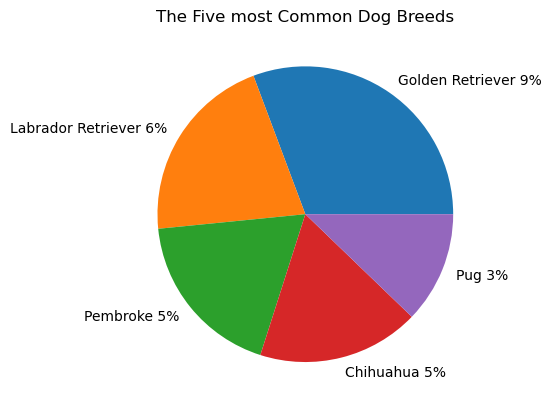

In [87]:
labels = np.full(len(top_five.value_counts()), "", dtype=object)
# top_breeds
for x in range(5):
    labels[x] = top_five.index[x] + " " + (top_five[x]*100).astype('int').astype('str') + "%"

plt.pie(top_five, labels=labels)
plt.title('The Five most Common Dog Breeds')
plt.show()

The above pie chart only shows the five most common dog breeds from the data set but gives their percentage of the whole dataset.

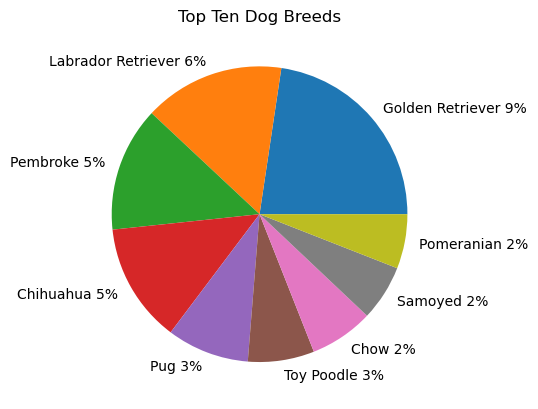

In [99]:
top_ten = tweetdf.breed.value_counts(normalize = True).head(9)
# labels = np.full(len(top_ten.breed.value_counts()), "", dtype=object)
labels = np.full(len(top_ten.value_counts()), "", dtype=object)
for x in range(9):
    labels[x] = top_ten.index[x] + " " + (top_ten[x]*100).astype('int').astype('str') + "%"
    
plt.pie(top_ten, labels=labels)
plt.title('Top Ten Dog Breeds')
plt.show()

Golden Retriever is the clear favorite of dogs who's breed was identified in this collection, with a count of 156. Labrador Retriever, Pembroke and Chihuahua are the next most popular with 106, 94 and 90 respectively.

These top five breeds combined represent only 30% of the dogs in the set with 113 breeds represented.

### Insight Three
I expect that the older a tweet is the more likes and retweets it will have. I will combine those values into a `tweet_love` column and create visualizations to explore this idea.

In [89]:
# add a column `tweet_age`
# populate `tweet_age` with the days from the max timestamp and the timestamp for the tweet
# add tweet_love column and populate with avg of retweet and favorite
end_date = max(tweetdf['timestamp'])
start_date = min(tweetdf['timestamp'])
span = end_date - start_date

tweetdf['tweet_age'] = (tweetdf['timestamp'].dt.date - min(tweetdf['timestamp'].dt.date))
tweetdf['tweet_age'] = tweetdf['tweet_age'].dt.days
tweetdf['tweet_age'] = tweetdf['tweet_age'].astype(int)
# some efforts to weight values differently. None of them made an appreciable difference
# tweetdf['tweet_love'] = (tweetdf.retweet_count * 2) + tweetdf.favorite_count
# tweetdf['tweet_love'] = ((tweetdf.retweet_count * 2) + tweetdf.favorite_count) /2
# tweetdf['tweet_love'] = (tweetdf.retweet_count + tweetdf.favorite_count) /2
tweetdf['tweet_love'] = tweetdf.retweet_count + tweetdf.favorite_count
tweetdf.tweet_love.describe()

count      2094.000000
mean      11831.369628
std       16614.453865
min          97.000000
25%        2703.750000
50%        5648.000000
75%       14810.000000
max      210590.000000
Name: tweet_love, dtype: float64

I have created a `tweet_love` column which is the retweet and favorite values combined:  (`tweet_love` = `retweet_count` + `favorite_count`) as they are both indicators of appreciation of the original tweet.

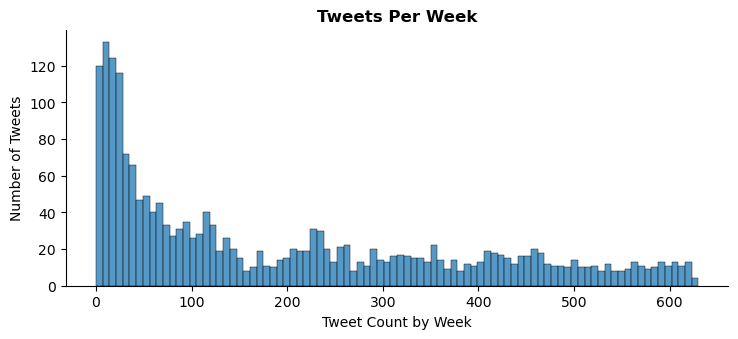

In [90]:
tpd = sb.displot(tweetdf, x="tweet_age", binwidth=7)
# tpd.fig.set_size_inches(14, 4)
tpd.fig.set_size_inches(8, 3)
# tpd.fig.set_size_inches(10, 5)
plt.title('Tweets per Week'.title(), weight='bold')
plt.xlabel('Tweet Count by Week')
plt.ylabel('Number of Tweets');

In [91]:
# tweetdf['tweet_age'] = (max(tweetdf['timestamp'].dt.date) - tweetdf['timestamp'].dt.date)
# tweetdf['tweet_age'].value_counts()

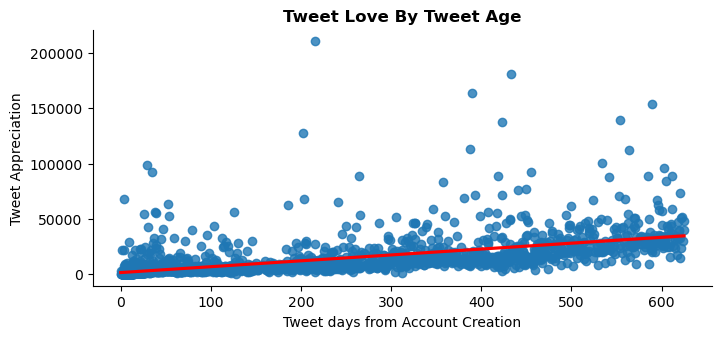

In [92]:
tc = sb.lmplot(data=tweetdf, x="tweet_age", y="tweet_love", line_kws={'color': 'red'})
# tc.fig.set_size_inches(14, 4)
tc.fig.set_size_inches(8, 3)
# tc.fig.set_size_inches(10, 5)
plt.title('Tweet Love by Tweet Age'.title(), weight='bold')
plt.xlabel('Tweet days from Account Creation')
plt.ylabel('Tweet Appreciation');

The charts show exactly the opposite from what I expected. I believe this for two reasons. First, I failed to consider that the data is from the start of the account, when he had few followers. Secondly, I suspect twitter followers are less likely to scroll back to older posts, and so the majority of a posts likes and retweets are gained in the first few hours or days. I do not have enough data to test these ideas.

It is interesting to see the outliers. I assume these are posts which have gone viral and received many more views, likes and retweets than the average post.

### Bonus Insight <a id="bonus"></a>
A look at the top 10 most loved tweets (`tweet_love` = `retweet_count` + `favorite_count`) shows that a five of them are video clips, three have two or more photos and only two are a single photo. If a picture is worth a thousand words, two must be worth at least two thousand words and video, especially a video of a cute puppy or dog, must be worth ten thousand words.

Please enjoy the top ten most loved posts from WeRateDogs.

In [101]:
# get the top 10 most loved tweets
viral_tweets = tweetdf.loc[tweetdf['tweet_love'] > 100000].sort_values(by=['tweet_love'])

#extract the URLs from the text strings
pattern = r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)'
viral_tweets['urls'] = viral_tweets['text'].str.extract(pattern, expand=False).str.strip()

# output the urls for the the viral_tweets
viral_tweets.urls

141    https://t.co/g2nSyGenG9
99     https://t.co/T1xlgaPujm
420    https://t.co/f1h2Fsalv9
862    https://t.co/YcXgHfp1EC
349    https://t.co/AdPKrI8BZ1
115    https://t.co/wk7TfysWHr
60     https://t.co/UDT7ZkcTgY
418    https://t.co/DkBYaCAg2d
324    https://t.co/nTz3FtorBc
823    https://t.co/7wE9LTEXC4
Name: urls, dtype: object